# Lending Club
---

Here we document our experiment with lending club data set.


In [2]:
import numpy as np

In [3]:
!wget https://storage.googleapis.com/open_data_file/final.zip

--2021-07-11 21:52:48--  https://storage.googleapis.com/open_data_file/final.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.251.2.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3996933 (3.8M) [application/x-zip-compressed]
Saving to: ‘final.zip’

final.zip           100%[===================>]   3.81M  --.-KB/s    in 0.02s   

2021-07-11 21:52:48 (193 MB/s) - ‘final.zip’ saved [3996933/3996933]



In [4]:
!ls

final.zip  sample_data


In [5]:
!unzip final.zip

Archive:  final.zip
   creating: final/
  inflating: final/test_final.csv    
  inflating: final/Description.xlsx  
  inflating: __MACOSX/final/._Description.xlsx  
  inflating: final/train_final.csv   


In [6]:
import pandas as pd
train = pd.read_csv("final/train_final.csv", engine='python')
test = pd.read_csv("final/test_final.csv", engine='python')

In [7]:
[x for x in train.columns.to_list() if x.startswith('continuous')]

['continuous_annual_inc',
 'continuous_annual_inc_joint',
 'continuous_delinq_2yrs',
 'continuous_dti',
 'continuous_dti_joint',
 'continuous_fico_range_high',
 'continuous_fico_range_low',
 'continuous_funded_amnt',
 'continuous_funded_amnt_inv',
 'continuous_inq_last_6mths',
 'continuous_installment',
 'continuous_int_rate',
 'continuous_last_fico_range_high',
 'continuous_last_fico_range_low',
 'continuous_loan_amnt',
 'continuous_mths_since_last_delinq',
 'continuous_mths_since_last_major_derog',
 'continuous_mths_since_last_record',
 'continuous_open_acc',
 'continuous_pub_rec']

In [8]:
train['continuous_loan_amnt'].describe(percentiles=np.arange(0, 1, 0.05))

count    50000.00000
mean     14332.53650
std       8617.58487
min       1000.00000
0%        1000.00000
5%        3000.00000
10%       4800.00000
15%       5500.00000
20%       6300.00000
25%       7775.00000
30%       8500.00000
35%      10000.00000
40%      10000.00000
45%      11600.00000
50%      12000.00000
55%      14000.00000
60%      15000.00000
65%      16000.00000
70%      18000.00000
75%      20000.00000
80%      21000.00000
85%      24000.00000
90%      28000.00000
95%      32000.00000
max      35000.00000
Name: continuous_loan_amnt, dtype: float64

In [9]:
train[['loan_status', 'continuous_loan_amnt']].groupby('loan_status').describe(percentiles=np.arange(0, 1, 0.1))

continuous_loan_amnt                ...                  
                           count          mean  ...      90%      max
loan_status                                     ...                  
0                        10212.0  15622.400118  ...  28000.0  35000.0
1                        39788.0  14001.479718  ...  27200.0  35000.0

[2 rows x 15 columns]

In [10]:
train['discrete_is_loan_10000'] = (train['continuous_loan_amnt']==10000).astype(np.int64)

In [11]:
train['discrete_is_loan_10000'].value_counts()

0    46323
1     3677
Name: discrete_is_loan_10000, dtype: int64

In [12]:
pd.crosstab(train['discrete_is_loan_10000'],train['loan_status'])

loan_status,0,1
discrete_is_loan_10000,,
0,9590,36733
1,622,3055


In [13]:
train_new = train.sample(frac=1)

In [14]:
train.head()

,continuous_annual_inc,continuous_annual_inc_joint,continuous_delinq_2yrs,continuous_dti,continuous_dti_joint,continuous_fico_range_high,continuous_fico_range_low,continuous_funded_amnt,continuous_funded_amnt_inv,continuous_inq_last_6mths,continuous_installment,continuous_int_rate,continuous_last_fico_range_high,continuous_last_fico_range_low,continuous_loan_amnt,loan_status,continuous_mths_since_last_delinq,continuous_mths_since_last_major_derog,continuous_mths_since_last_record,continuous_open_acc,continuous_pub_rec,discrete_addr_state_1_one_hot,discrete_addr_state_2_one_hot,discrete_addr_state_3_one_hot,discrete_addr_state_4_one_hot,discrete_addr_state_5_one_hot,discrete_addr_state_6_one_hot,discrete_addr_state_7_one_hot,discrete_addr_state_8_one_hot,discrete_addr_state_9_one_hot,discrete_addr_state_10_one_hot,discrete_addr_state_11_one_hot,discrete_addr_state_12_one_hot,discrete_addr_state_13_one_hot,discrete_addr_state_14_one_hot,discrete_addr_state_15_one_hot,discrete_addr_state_16_one_hot,discrete_addr_state_17_one_hot,discrete_addr_state_18_one_hot,discrete_addr_state_19_one_hot,...,discrete_purpose_12_one_hot,discrete_pymnt_plan_1_one_hot,discrete_sub_grade_1_one_hot,discrete_sub_grade_2_one_hot,discrete_sub_grade_3_one_hot,discrete_sub_grade_4_one_hot,discrete_sub_grade_5_one_hot,discrete_sub_grade_6_one_hot,discrete_sub_grade_7_one_hot,discrete_sub_grade_8_one_hot,discrete_sub_grade_9_one_hot,discrete_sub_grade_10_one_hot,discrete_sub_grade_11_one_hot,discrete_sub_grade_12_one_hot,discrete_sub_grade_13_one_hot,discrete_sub_grade_14_one_hot,discrete_sub_grade_15_one_hot,discrete_sub_grade_16_one_hot,discrete_sub_grade_17_one_hot,discrete_sub_grade_18_one_hot,discrete_sub_grade_19_one_hot,discrete_sub_grade_20_one_hot,discrete_sub_grade_21_one_hot,discrete_sub_grade_22_one_hot,discrete_sub_grade_23_one_hot,discrete_sub_grade_24_one_hot,discrete_sub_grade_25_one_hot,discrete_sub_grade_26_one_hot,discrete_sub_grade_27_one_hot,discrete_sub_grade_28_one_hot,discrete_sub_grade_29_one_hot,discrete_sub_grade_30_one_hot,discrete_sub_grade_31_one_hot,discrete_sub_grade_32_one_hot,discrete_sub_grade_33_one_hot,discrete_sub_grade_34_one_hot,discrete_sub_grade_35_one_hot,discrete_term_1_one_hot,discrete_term_2_one_hot,discrete_is_loan_10000
0,55000.0,NaN,0.0,5.91,NaN,679.0,675.0,3600.0,3600.0,1.0,123.03,13.99,564.0,560.0,3600.0,1,30.0,30.0,NaN,7.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,65000.0,NaN,1.0,16.06,NaN,719.0,715.0,24700.0,24700.0,4.0,820.28,11.99,699.0,695.0,24700.0,1,6.0,NaN,NaN,22.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,63000.0,71000.0,0.0,10.78,13.85,699.0,695.0,20000.0,20000.0,0.0,432.66,10.78,704.0,700.0,20000.0,1,NaN,NaN,NaN,6.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,104433.0,NaN,1.0,25.37,NaN,699.0,695.0,10400.0,10400.0,3.0,289.91,22.45,704.0,700.0,10400.0,1,12.0,NaN,NaN,12.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,34000.0,NaN,0.0,10.20,NaN,694.0,690.0,11950.0,11950.0,0.0,405.18,13.44,759.0,755.0,11950.0,1,NaN,NaN,NaN,5.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [15]:
train_new.head()

,continuous_annual_inc,continuous_annual_inc_joint,continuous_delinq_2yrs,continuous_dti,continuous_dti_joint,continuous_fico_range_high,continuous_fico_range_low,continuous_funded_amnt,continuous_funded_amnt_inv,continuous_inq_last_6mths,continuous_installment,continuous_int_rate,continuous_last_fico_range_high,continuous_last_fico_range_low,continuous_loan_amnt,loan_status,continuous_mths_since_last_delinq,continuous_mths_since_last_major_derog,continuous_mths_since_last_record,continuous_open_acc,continuous_pub_rec,discrete_addr_state_1_one_hot,discrete_addr_state_2_one_hot,discrete_addr_state_3_one_hot,discrete_addr_state_4_one_hot,discrete_addr_state_5_one_hot,discrete_addr_state_6_one_hot,discrete_addr_state_7_one_hot,discrete_addr_state_8_one_hot,discrete_addr_state_9_one_hot,discrete_addr_state_10_one_hot,discrete_addr_state_11_one_hot,discrete_addr_state_12_one_hot,discrete_addr_state_13_one_hot,discrete_addr_state_14_one_hot,discrete_addr_state_15_one_hot,discrete_addr_state_16_one_hot,discrete_addr_state_17_one_hot,discrete_addr_state_18_one_hot,discrete_addr_state_19_one_hot,...,discrete_purpose_12_one_hot,discrete_pymnt_plan_1_one_hot,discrete_sub_grade_1_one_hot,discrete_sub_grade_2_one_hot,discrete_sub_grade_3_one_hot,discrete_sub_grade_4_one_hot,discrete_sub_grade_5_one_hot,discrete_sub_grade_6_one_hot,discrete_sub_grade_7_one_hot,discrete_sub_grade_8_one_hot,discrete_sub_grade_9_one_hot,discrete_sub_grade_10_one_hot,discrete_sub_grade_11_one_hot,discrete_sub_grade_12_one_hot,discrete_sub_grade_13_one_hot,discrete_sub_grade_14_one_hot,discrete_sub_grade_15_one_hot,discrete_sub_grade_16_one_hot,discrete_sub_grade_17_one_hot,discrete_sub_grade_18_one_hot,discrete_sub_grade_19_one_hot,discrete_sub_grade_20_one_hot,discrete_sub_grade_21_one_hot,discrete_sub_grade_22_one_hot,discrete_sub_grade_23_one_hot,discrete_sub_grade_24_one_hot,discrete_sub_grade_25_one_hot,discrete_sub_grade_26_one_hot,discrete_sub_grade_27_one_hot,discrete_sub_grade_28_one_hot,discrete_sub_grade_29_one_hot,discrete_sub_grade_30_one_hot,discrete_sub_grade_31_one_hot,discrete_sub_grade_32_one_hot,discrete_sub_grade_33_one_hot,discrete_sub_grade_34_one_hot,discrete_sub_grade_35_one_hot,discrete_term_1_one_hot,discrete_term_2_one_hot,discrete_is_loan_10000
16272,76000.0,NaN,1.0,7.86,NaN,664.0,660.0,3600.0,3550.0,0.0,119.56,11.99,674.0,670.0,3600.0,1,8.0,NaN,98.0,13.0,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
16190,140000.0,NaN,0.0,11.62,NaN,724.0,720.0,28000.0,28000.0,0.0,843.22,5.32,804.0,800.0,28000.0,1,NaN,NaN,NaN,7.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
11708,40000.0,NaN,0.0,14.91,NaN,684.0,680.0,7000.0,7000.0,0.0,234.48,12.59,529.0,525.0,7000.0,0,NaN,NaN,NaN,7.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
17420,48000.0,NaN,0.0,16.45,NaN,669.0,665.0,19100.0,19100.0,2.0,657.26,14.48,664.0,660.0,19100.0,1,79.0,NaN,77.0,9.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4319,82000.0,NaN,0.0,25.93,NaN,674.0,670.0,1600.0,1600.0,1.0,52.75,11.48,619.0,615.0,1600.0,1,30.0,76.0,51.0,13.0,2.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [16]:
train_new.to_csv("train_new.csv", index=False)

In [17]:
len(train_new.columns.to_list())

147

In [18]:
import io
import multiprocessing
from contextlib import redirect_stdout
from copy import deepcopy
from dataclasses import dataclass, asdict
import hyperopt.pyll
from hyperopt import fmin, tpe, hp
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import torch

import copy
cpu_count = 4
use_gpu = False
@dataclass
class LGBOpt:
    num_threads: any = hp.choice('num_threads', [cpu_count])
    num_leaves: any = hp.choice('num_leaves', [64])
    metric: any = hp.choice('metric', ['binary_error'])
    num_round: any = hp.choice('num_rounds', [1000])
    objective: any = hp.choice('objective', ['binary'])
    learning_rate: any = hp.uniform('learning_rate', 0.01, 0.1)
    feature_fraction: any = hp.uniform('feature_fraction', 0.5, 1.0)
    bagging_fraction: any = hp.uniform('bagging_fraction', 0.8, 1.0)
    device_type: any = hp.choice('device_tpye', ['gpu']) if use_gpu else hp.choice('device_type',
                                                                                   ['cpu'])
    boosting: any = hp.choice('boosting', ['gbdt', 'dart', 'goss'])
    extra_trees: any = hp.choice('extra_tress', [False, True])
    drop_rate: any = hp.uniform('drop_rate', 0, 0.2)
    uniform_drop: any = hp.choice('uniform_drop', [True, False])
    lambda_l1: any = hp.uniform('lambda_l1', 0, 10)  # TODO: Check range
    lambda_l2: any = hp.uniform('lambda_l2', 0, 10)  # TODO: Check range
    min_gain_to_split: any = hp.uniform('min_gain_to_split', 0, 1)  # TODO: Check range
    min_data_in_bin = hp.choice('min_data_in_bin', [3, 5, 10, 15, 20, 50])

    @staticmethod
    def get_common_params():
        return {'num_thread': 4, 'num_leaves': 12, 'metric': 'binary', 'objective': 'binary',
                'num_round': 1000, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
    

In [19]:
class FitterBase(object):
    def __init__(self, label, metric, max_eval=100, opt=None):
        self.label = label
        self.metric = metric
        self.opt_params = dict()
        self.max_eval = max_eval
        self.opt = opt

    def get_loss(self, y, y_pred):
        if self.metric == 'error':
            return 1 - accuracy_score(y, y_pred)
        elif self.metric == 'precision':
            return 1 - precision_score(y, y_pred)
        elif self.metric == 'recall':
            return 1 - recall_score(y, y_pred)
        elif self.metric == 'macro_f1':
            return 1 - f1_score(y, y_pred, average='macro')
        elif self.metric == 'micro_f1':
            return 1 - f1_score(y, y_pred, average='micro')
        elif self.metric == 'auc':  # TODO: Add a warning checking if y_predict is all [0, 1], it should be probability
            return 1 - roc_auc_score(y, y_pred)
        else:
            raise Exception("Not implemented yet.")

In [20]:
class LGBFitter(FitterBase):
    def __init__(self, label='label', metric='error', opt: LGBOpt = None, max_eval=100):
        super(LGBFitter, self).__init__(label, metric, max_eval)
        if opt is not None:
            self.opt = opt
        else:
            self.opt = LGBOpt()
        self.best_round = None
        self.clf = None

    def train(self, train_df, eval_df, params=None, use_best_eval=True):
        self.best_round = None
        dtrain = lgb.Dataset(train_df.drop(columns=[self.label]), train_df[self.label])
        deval = lgb.Dataset(eval_df.drop(columns=[self.label]), eval_df[self.label])
        evallist = [dtrain, deval]
        if params is None:
            use_params = deepcopy(self.opt_params)
        else:
            use_params = deepcopy(params)

        num_round = use_params.pop('num_round')
        if use_best_eval:
            with io.StringIO() as buf, redirect_stdout(buf):
                self.clf = lgb.train(use_params, dtrain, num_round, valid_sets=evallist)
                output = buf.getvalue().split("\n")
            min_error = np.inf
            min_index = 0
            for idx in range(len(output) - 1):
                if len(output[idx].split("\t")) == 3:
                    temp = float(output[idx].split("\t")[2].split(":")[1])
                    if min_error > temp:
                        min_error = temp
                        min_index = int(output[idx].split("\t")[0][1:-1])
            print("The minimum is attained in round %d" % (min_index + 1))
            self.best_round = min_index + 1
            return output
        else:
            with io.StringIO() as buf, redirect_stdout(buf):
                self.clf = lgb.train(use_params, dtrain, num_round, valid_sets=evallist)
                output = buf.getvalue().split("\n")
            self.best_round = num_round
            return output

    def search(self, train_df, eval_df, use_best_eval=True):
        self.opt_params = dict()

        def train_impl(params):
            self.train(train_df, eval_df, params, use_best_eval)
            if self.metric == 'auc':
                y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
            else:
                y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                           num_iteration=self.best_round) > 0.5).astype(int)
            return self.get_loss(eval_df[self.label], y_pred)

        self.opt_params = fmin(train_impl, asdict(self.opt), algo=tpe.suggest, max_evals=self.max_eval)

    def search_k_fold(self, k_fold, data, use_best_eval=True):
        self.opt_params = dict()

        def train_impl_nfold(params):
            loss = list()
            for train_id, eval_id in k_fold.split(data):
                train_df = data.loc[train_id]
                eval_df = data.loc[eval_id]
                self.train(train_df, eval_df, params, use_best_eval)
                if self.metric == 'auc':
                    y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
                else:
                    y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                               num_iteration=self.best_round) > 0.5).astype(int)
                loss.append(self.get_loss(eval_df[self.label], y_pred))
            return np.mean(loss)

        self.opt_params = fmin(train_impl_nfold, asdict(self.opt), algo=tpe.suggest, max_evals=self.max_eval)

    def train_k_fold(self, k_fold, train_data, test_data, params=None, drop_test_y=True, use_best_eval=True):
        acc_result = list()
        train_pred = np.empty(train_data.shape[0])
        test_pred = np.empty(test_data.shape[0])
        if drop_test_y:
            dtest = test_data.drop(columns=self.label)
        else:
            dtest = test_data

        models = list()
        for train_id, eval_id in k_fold.split(train_data):
            train_df = train_data.loc[train_id]
            eval_df = train_data.loc[eval_id]
            self.train(train_df, eval_df, params, use_best_eval)
            models.append(copy.deepcopy(self.clf))
            train_pred[eval_id] = self.clf.predict(eval_df.drop(columns=self.label), num_iteration=self.best_round)
            if self.metric == 'auc':
                y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
            else:
                y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                           num_iteration=self.best_round) > 0.5).astype(int)
            acc_result.append(self.get_loss(eval_df[self.label], y_pred))
            test_pred += self.clf.predict(dtest, num_iteration=self.best_round)
        test_pred /= k_fold.n_splits
        return train_pred, test_pred, acc_result, models

In [21]:
fitter = LGBFitter(label='loan_status')

In [22]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)
for num_leaves in [32]:
    params = {'num_thread': 4, 'num_leaves': num_leaves, 'metric': 'binary', 'objective': 'binary',
                'num_round': 1000, 'learning_rate': 0.02, 'feature_fraction': 0.8,
           'bagging_fraction': 0.8}
    train_pred, test_pred, error_rate, models = fitter.train_k_fold(kfold, train_new, test, params = params)
    print(params)
    print(np.mean(error_rate))

The minimum is attained in round 419
The minimum is attained in round 263
The minimum is attained in round 305
The minimum is attained in round 271
The minimum is attained in round 291
{'num_thread': 4, 'num_leaves': 32, 'metric': 'binary', 'objective': 'binary', 'num_round': 1000, 'learning_rate': 0.02, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
0.08116000000000001


In [23]:
1 - accuracy_score(test['loan_status'], (test_pred > 0.5).astype(np.int64))

0.08235999999999999

In [24]:
TRAIN_INDEX = train_new.shape[0]
TEST_INDEX = test.shape[0] + TRAIN_INDEX

In [25]:
data = pd.concat([train_new, test], axis=0)

In [26]:
data['discrete_is_loan_10000'] = (data['continuous_loan_amnt']==1).astype(np.int64)

In [27]:
data.shape[1]

147

In [28]:
train_add = data.iloc[0:TRAIN_INDEX, :]
test_add = data.iloc[TRAIN_INDEX:TEST_INDEX, :]

In [29]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)
for num_leaves in [32]:
    params = {'num_thread': 4, 'num_leaves': num_leaves, 'metric': 'binary', 'objective': 'binary',
                'num_round': 1000, 'learning_rate': 0.02, 'feature_fraction': 0.8,
           'bagging_fraction': 0.8}
    train_pred, test_pred, error_rate, models = fitter.train_k_fold(kfold, train_add, test_add, params = params)
    print(params)
    print(np.mean(error_rate))

The minimum is attained in round 406
The minimum is attained in round 313
The minimum is attained in round 290
The minimum is attained in round 261
The minimum is attained in round 266
{'num_thread': 4, 'num_leaves': 32, 'metric': 'binary', 'objective': 'binary', 'num_round': 1000, 'learning_rate': 0.02, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
0.08104


# Why it doesn't work?
---
In LigthGBM, the algorithm will automatically create binnings. In this case, since about 10% of the "loan amount" is exactly $10000, it will automatically fall into a bin. Therefore, adding the additional data will not work.  

In [51]:
# We can find the most important variables in the following ways.
features = train_new.drop(columns='loan_status').columns.to_list()
importance = models[1].feature_importance(importance_type = 'gain')

feautre_importance = sorted(zip(features, importance), key = lambda x : x[1], reverse=True)
print(feautre_importance)

[('continuous_last_fico_range_high', 491499.4841578007), ('continuous_last_fico_range_low', 98149.5388301611), ('discrete_term_1_one_hot', 21600.887171566486), ('continuous_dti', 16397.584515571594), ('continuous_installment', 13121.578148841858), ('continuous_annual_inc', 11530.843480825424), ('continuous_mths_since_last_delinq', 10349.731641590595), ('continuous_int_rate', 8650.100816488266), ('continuous_funded_amnt', 8635.520898461342), ('continuous_fico_range_high', 8444.5760627985), ('continuous_open_acc', 8082.108596801758), ('discrete_term_2_one_hot', 6628.272376000881), ('continuous_mths_since_last_major_derog', 6492.57046598196), ('continuous_mths_since_last_record', 6084.435826301575), ('continuous_funded_amnt_inv', 5174.274967074394), ('discrete_emp_length_12_one_hot', 3707.2046729922295), ('continuous_inq_last_6mths', 2503.0863552093506), ('continuous_fico_range_low', 1933.8615772724152), ('discrete_home_ownership_1_one_hot', 1610.3601933121681), ('discrete_purpose_1_one_h

# SHAP and force plots
---
In this code snippet, we demonstrate the process of using SHAP values and force plots to examine the cause of bad cases. Additional information can be found [here](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html).

In [30]:
!pip install shap

In [46]:
import shap
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(train_add.drop(columns='loan_status')) # This will take some time

KeyboardInterrupt: ignored

In [ ]:
x = train_add.drop(columns='loan_status')
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], x.iloc[0,:])


# Learning a Bayesian Network
---
This small example demonstrates how to create a Bayesian Network using R. Pay attention that it is usually desirable to input discretized data! 

In [31]:
%load_ext rpy2.ipython

In [32]:
%%R
install.packages("bnlearn")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/bnlearn_4.6.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1287342 bytes (1.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

In [33]:
%%R
library(bnlearn)

In [34]:
%%R
data(marks)

In [35]:
%%R
summary(marks)

      MECH            VECT            ALG             ANL       
 Min.   : 0.00   Min.   : 9.00   Min.   :15.00   Min.   : 9.00  
 1st Qu.:30.00   1st Qu.:42.00   1st Qu.:45.00   1st Qu.:35.75  
 Median :41.50   Median :51.00   Median :50.00   Median :49.00  
 Mean   :38.95   Mean   :50.59   Mean   :50.60   Mean   :46.68  
 3rd Qu.:49.25   3rd Qu.:60.00   3rd Qu.:57.25   3rd Qu.:57.00  
 Max.   :77.00   Max.   :82.00   Max.   :80.00   Max.   :70.00  
      STAT      
 Min.   : 9.00  
 1st Qu.:31.00  
 Median :40.00  
 Mean   :42.31  
 3rd Qu.:51.50  
 Max.   :81.00  


In [36]:
%%R
bn.gs = gs(marks)

In [37]:
%%R
bn.gs


  Bayesian network learned via Constraint-based methods

  model:
    [undirected graph]
  nodes:                                 5 
  arcs:                                  6 
    undirected arcs:                     6 
    directed arcs:                       0 
  average markov blanket size:           2.40 
  average neighbourhood size:            2.40 
  average branching factor:              0.00 

  learning algorithm:                    Grow-Shrink 
  conditional independence test:         Pearson's Correlation 
  alpha threshold:                       0.05 
  tests used in the learning procedure:  80 



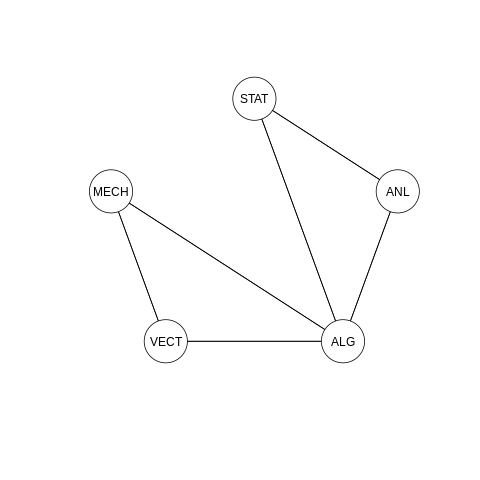

In [38]:
%%R
plot(bn.gs)